In [ ]:
# !pip install tensorflow keras pillow pyttsx3

# !pip install -q kaggle

# !pip install Opendatasets

# import opendatasets as od
# import pandas
# data_dir = od.download(
#     "https://www.kaggle.com/datasets/gopalbhattrai/pascal-voc-2012-dataset",
#     force=True,
#     data_dir='pascal-voc-2012-dataset'  # Specify a different extraction directory
# )

start from here

In [2]:
# Step 1: Clone the OIDv4 Toolkit and Install Dependencies
!git clone https://github.com/EscVM/OIDv4_ToolKit.git
%cd OIDv4_ToolKit
!pip install -r requirements.txt

# Step 2: Download Images for a Specific Class
# Replace "Dog" with the class you want, e.g., "Cat", "Car"
!python main.py downloader --classes "Dog" --type_csv train --limit 100

# Step 3: Mount Google Drive for Storage
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Step 4: Move Dataset to Google Drive
# Ensure the correct path is used for the downloaded dataset
!mv OID/Dataset /content/drive/MyDrive/OpenImages

# Step 5: Verify the Download
# List the downloaded images under the correct path
!ls /content/drive/MyDrive/OpenImages/train/Dog


Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 422, done.
remote: Total 422 (delta 0), reused 0 (delta 0), pack-reused 422 (from 1)
Receiving objects: 100% (422/422), 34.08 MiB | 11.61 MiB/s, done.
Resolving deltas: 100% (146/146), done.
/content/OIDv4_ToolKit
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.2/83.2 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9
    Uninstalling rsa-4.9:
      Successfully uninstalled rsa-4.9
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This 

In [3]:
!pip install gTTS

import tensorflow as tf
import numpy as np
import json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50, MobileNet
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from tensorflow.keras.applications.mobilenet import preprocess_input as preprocess_input_mobilenet
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from gtts import gTTS
import pyttsx3
import IPython.display as ipd
from pycocotools.coco import COCO
import requests
from io import BytesIO
from PIL import Image

data_dir = "/content/drive/MyDrive/OpenImages/Dataset"

import pathlib
data_dir= pathlib.Path(data_dir)  #to add dataset path in directory
data_dir

list(data_dir.glob('*/*.jpg'))[:5]

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


In [4]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
import cv2
import keras
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Input, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector, Concatenate
from keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
import random
from keras.preprocessing import image, sequence
from tensorflow.keras.applications.xception import preprocess_input as preprocess_xception
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_inception
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Concatenate, Dense
from tensorflow.keras.models import Model
import torch
from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import requests
from gtts import gTTS
import IPython.display as ipd

In [5]:

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

0


In [6]:

# Load the BLIP processor and model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [7]:
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)

    # Preprocess for Xception and InceptionV3
    img_xception = preprocess_xception(img_array)
    img_inception = preprocess_inception(img_array)

    # Expand dimensions to match input shape for both models
    img_xception = np.expand_dims(img_xception, axis=0)
    img_inception = np.expand_dims(img_inception, axis=0)

    return img_xception, img_inception

In [9]:
# Function to add prefix to layer names
def add_prefix_to_layers(model, prefix):
    for layer in model.layers:
        layer._name = prefix + layer.name

# Load Pretrained Models
xception_model = Xception(weights='imagenet', include_top=False)
add_prefix_to_layers(xception_model, "xception_")

inception_model = InceptionV3(weights='imagenet', include_top=False)
add_prefix_to_layers(inception_model, "inception_")

# Load Pretrained Models
xception_model = Xception(weights='imagenet', include_top=False)
inception_model = InceptionV3(weights='imagenet', include_top=False)

img_path = "/content/drive/MyDrive/OpenImages/Dataset/train/Dog/0822c77ead50a868.jpg"  # Removed extra '.jpg' from the file name
img_xception, img_inception = load_and_preprocess_image(img_path, target_size=(299, 299))

# Preprocess for Xception and InceptionV3
img_xception = preprocess_xception(img_xception)
img_inception = preprocess_inception(img_inception)

In [10]:
from tensorflow.keras.applications import Xception, InceptionV3
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load pretrained models without top layers
xception_model = Xception(include_top=False, weights='imagenet', input_shape=(299, 299, 3))
inception_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(299, 299, 3))

# Unfreeze some layers in the pretrained models for fine-tuning
for layer in xception_model.layers[-10:]:
    layer.trainable = True
for layer in inception_model.layers[-10:]:
    layer.trainable = True

def create_hybrid_model():
    # Inputs
    xception_input = Input(shape=(299, 299, 3), name='xception_input')
    inception_input = Input(shape=(299, 299, 3), name='inception_input')

    # Feature extraction
    xception_output = xception_model(xception_input)
    inception_output = inception_model(inception_input)

    # Global average pooling
    x_xception = GlobalAveragePooling2D()(xception_output)
    x_inception = GlobalAveragePooling2D()(inception_output)

    # Concatenate outputs
    concatenated = Concatenate()([x_xception, x_inception])

    # Fully connected layers
    x = Dense(512, activation='relu')(concatenated)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # Final predictions
    predictions = Dense(10, activation='softmax')(x)  # Adjust the output size to your task

    # Build the model
    model = Model(inputs=[xception_input, inception_input], outputs=predictions)
    return model

# Create the model
hybrid_model = create_hybrid_model()

In [11]:
# Compile the model
hybrid_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

hybrid_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ xception_input            │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_input           │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ xception (Functional)     │ (None, 10, 10, 2048)   │     20,861,480 │ xception_input[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ inception_v3 (Functional) │ (None, 8, 8, 2048)     │     21,802,784 │ inception_input[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 2048)           │              0 │ xception[0][0]         │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 2048)           │              0 │ inception_v3[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 4096)           │              0 │ global_average_poolin… │
│ (Concatenate)             │                        │                │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │      2,097,664 │ concatenate_10[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_490   │ (None, 512)            │          2,048 │ dense[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 256)            │        131,328 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_491   │ (None, 256)            │          1,024 │ dense_1[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 256)            │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 10)             │          2,570 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,898,898 (171.28 MB)

 Trainable params: 44,808,402 (170.93 MB)

 Non-trainable params: 90,496 (353.50 KB)

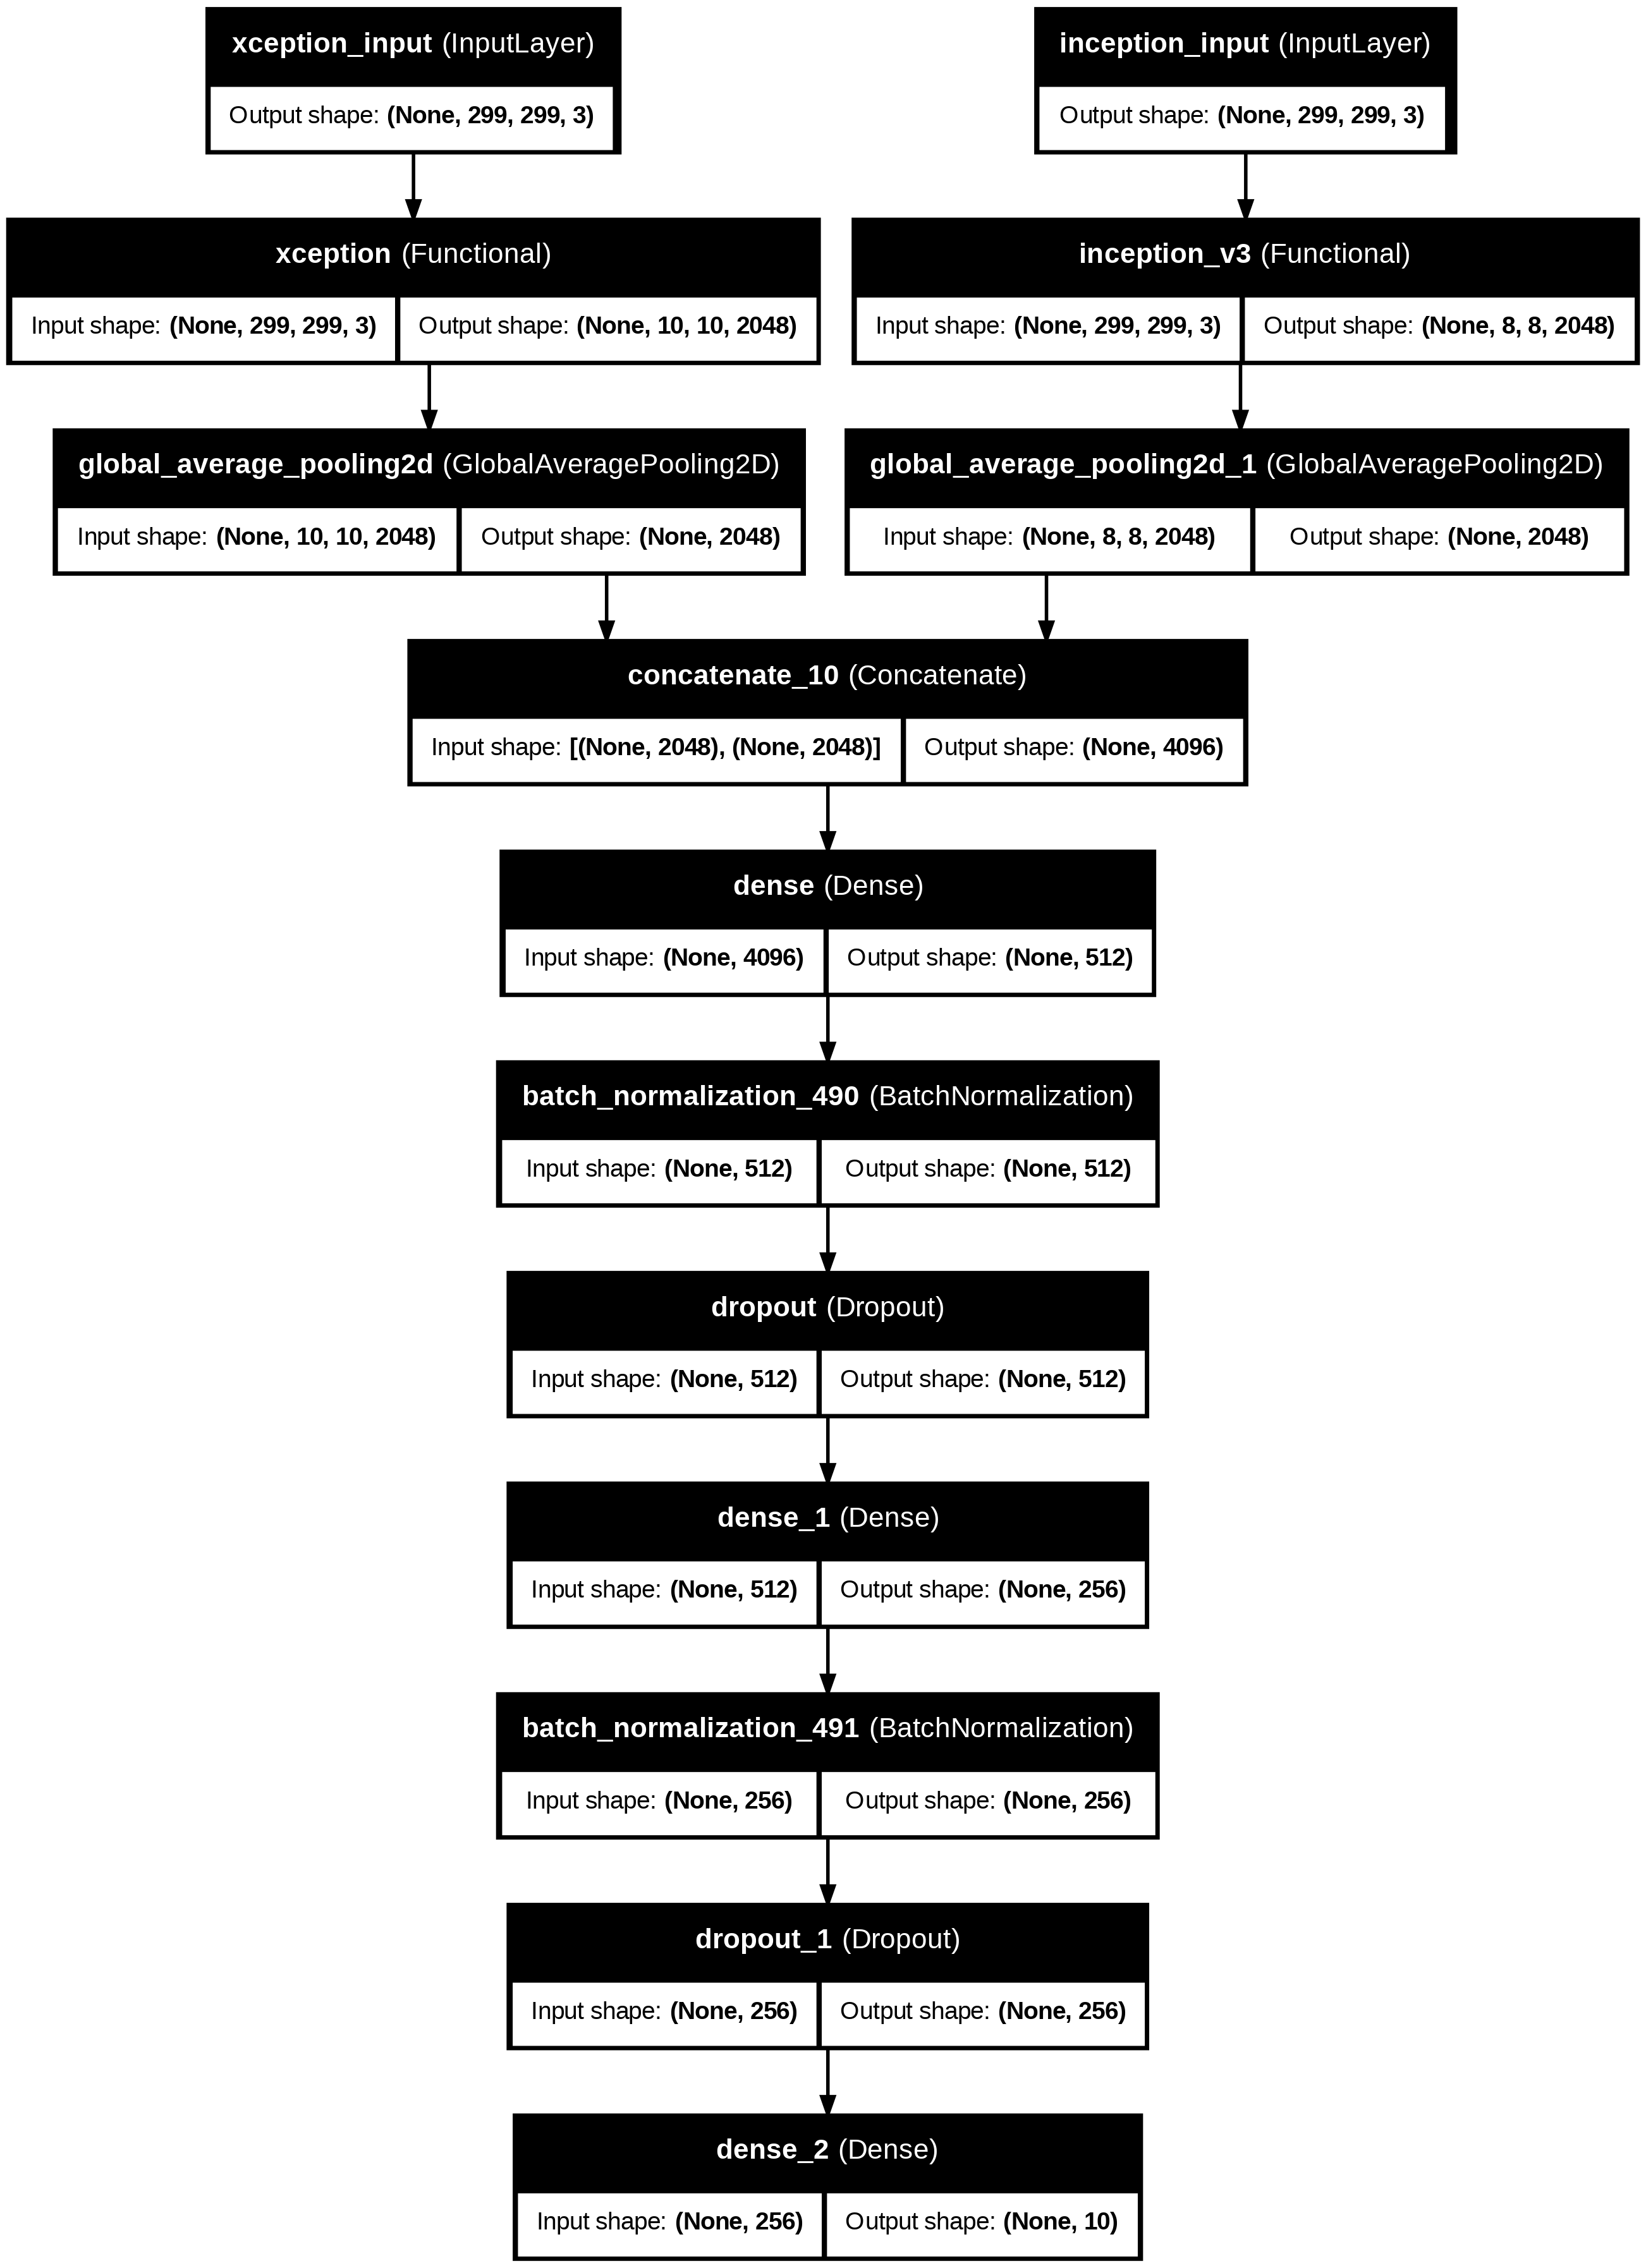

In [47]:
from tensorflow.keras.utils import plot_model

# Save the model diagram to a file
plot_model(hybrid_model, to_file='hybrid_model_diagram.png', show_shapes=True, show_layer_names=True)


In [13]:
def load_and_preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)

    # Preprocess for Xception and InceptionV3
    img_xception = preprocess_xception(img_array)
    img_inception = preprocess_inception(img_array)

    # Expand dimensions to match input shape for both models
    img_xception = np.expand_dims(img_xception, axis=0)
    img_inception = np.expand_dims(img_inception, axis=0)

    return img_xception, img_inception

In [14]:
img_path = '/content/drive/MyDrive/OpenImages/Dataset/train/Dog/0822c77ead50a868.jpg'  # replace with your image path
img_xception, img_inception = load_and_preprocess_image(img_path, target_size=(299, 299))


In [15]:
# Make prediction
preds = hybrid_model.predict([img_xception, img_inception])
predicted_class = np.argmax(preds[0])

# Load ImageNet labels
!wget https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
import json
with open('imagenet_class_index.json', 'r') as f:
    class_dict = json.load(f)
class_labels = {int(key): value[1] for key, value in class_dict.items()}

predicted_label = class_labels[predicted_class]
print("Predicted label:", predicted_label)

# Extract Features
features = hybrid_model.predict([img_xception, img_inception])

1/1 ━━━━━━━━━━━━━━━━━━━━ 18s 18s/step
--2024-12-15 03:12:59--  https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35363 (35K) [application/json]
Saving to: ‘imagenet_class_index.json’

imagenet_class_inde 100%[===================>]  34.53K  --.-KB/s    in 0.02s   

2024-12-15 03:12:59 (1.49 MB/s) - ‘imagenet_class_index.json’ saved [35363/35363]

Predicted label: cock
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


In [16]:
# Ensure transformers library is installed
!pip install -q transformers

from transformers import GPT2Tokenizer, TFGPT2LMHeadModel

# Load the tokenizer and the model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
captioning_model = TFGPT2LMHeadModel.from_pretrained("gpt2")

# Prepare input for the model
input_ids = tokenizer.encode("Features: ", return_tensors="tf")

# Prepare input for the model with attention mask
input_ids = tokenizer.encode("Features: ", return_tensors="tf")

# Create attention mask (no padding tokens, so all values are 1)
attention_mask = tf.ones_like(input_ids)

# Generate caption with attention mask and pad token ID
output = captioning_model.generate(
    input_ids,
    attention_mask=attention_mask,
    max_length=50,
    num_return_sequences=1,
    pad_token_id=tokenizer.eos_token_id  # Use eos_token_id as pad token for GPT-2
)

caption = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated caption:", caption)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Generated caption: Features:  The first thing I did was to create a new file called "config.json" which contains the following:
{ "name": "config.json", "version": "1.0", "description": "The default


In [ ]:
from graphviz import Digraph

def create_hybrid_model_flowchart():
    dot = Digraph(comment='Hybrid Model Flowchart')

    # Inputs
    dot.node('A', 'Input (299x299x3)')

    # Pretrained models
    dot.node('B', 'Xception Model (pretrained)')
    dot.node('D', 'InceptionV3 Model (pretrained)')
    dot.edge('A', 'B', label='Xception Input')
    dot.edge('A', 'D', label='Inception Input')

    # Global Average Pooling
    dot.node('C', 'Global Average Pooling')
    dot.node('E', 'Global Average Pooling')
    dot.edge('B', 'C')
    dot.edge('D', 'E')

    # Concatenate
    dot.node('F', 'Concatenate Features')
    dot.edge('C', 'F', label='Feature Vectors')
    dot.edge('E', 'F', label='Feature Vectors')

    # Dense Layers
    dot.node('G', 'Dense (512, ReLU)')
    dot.edge('F', 'G')

    dot.node('H', 'Batch Normalization')
    dot.edge('G', 'H')

    dot.node('I', 'Dropout (0.5)')
    dot.edge('H', 'I')

    dot.node('J', 'Dense (256, ReLU)')
    dot.edge('I', 'J')

    dot.node('K', 'Batch Normalization')
    dot.edge('J', 'K')

    dot.node('L', 'Dropout (0.5)')
    dot.edge('K', 'L')

    dot.node('M', 'Dense (10, Softmax)')
    dot.edge('L', 'M')

    dot.node('N', 'Predictions')
    dot.edge('M', 'N')

    # Render the graph
    return dot

# Generate the flowchart
flowchart = create_hybrid_model_flowchart()
flowchart.render('hybrid_model_flowchart', format='png', cleanup=True)


'hybrid_model_flowchart.png'

In [17]:

# Load and preprocess image
img_path = "/content/drive/MyDrive/OpenImages/Dataset/train/Dog/0822c77ead50a868.jpg"  # Local file path
img = Image.open(img_path)  # Open the image directly

# Preprocess the image using the BLIP processor
inputs = processor(img, return_tensors="pt")

In [18]:
!pip install -q transformers
from transformers import BlipForConditionalGeneration

# Assuming 'model' was originally a PretrainedResNetModel, replace it with:
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

# Now, the 'generate' method should be available
output = model.generate(**inputs)
caption = processor.decode(output[0], skip_special_tokens=True)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1375: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


In [19]:
print("Generated caption:", caption)

Generated caption: a dog sitting under a desk with a chair


In [20]:
!pip install deep_translator

!pip install deep_translator # Install deep_translator in the current environment

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.3 MB/s eta 0:00:00


In [21]:

from deep_translator import GoogleTranslator
from gtts import gTTS
import IPython.display as ipd
# Prompt user for language code
def get_language_code():
    # List of language codes for common languages
    languages = {
        'English': 'en',
        'Spanish': 'es',
        'French': 'fr',
        'German': 'de',
        'Chinese': 'zh',
        'Japanese': 'ja',
        'Korean': 'ko',
        'Italian': 'it',
        'Hindi': 'hi',
        'Tamil': 'ta',
        'Bengali': 'bn',
        'Telugu': 'te',
        'Punjabi': 'pa',
        'Marathi': 'mr',
        'Russian': 'ru',
        'Arabic': 'ar',
        'Portuguese': 'pt',
        'Dutch': 'nl',
        'Swedish': 'sv',
        'Norwegian': 'no',
        'Greek': 'el',
        'Turkish': 'tr',
        'Persian': 'fa',
    }

    print("Available languages:")
    for lang_name, lang_code in languages.items():
        print(f"{lang_name}: {lang_code}")

    lang_choice = input("Enter the language code (e.g., 'en', 'es'): ").strip()
    return lang_choice if lang_choice in languages.values() else 'en'  # Default to 'en' if not found

# Translate text to the desired language using deep_translator
def translate_text(text, dest_lang):
    translated = GoogleTranslator(source='auto', target=dest_lang).translate(text)
    return translated

# Convert text to speech
def text_to_speech(text, lang='en'):
    tts = gTTS(text=text, lang=lang)
    tts.save('caption.mp3')  # Save the speech to an MP3 file
    return 'caption.mp3'

# Example usage
language_code = get_language_code()  # Get language code from user

# Assuming 'caption' is already defined in the context
translated_caption = translate_text(caption, language_code)  # Translate caption
print(f"Translated Caption: {translated_caption}")

voice_output = text_to_speech(translated_caption, lang=language_code)  # Generate speech

# Play the audio
ipd.display(ipd.Audio(voice_output))  # This will play the generated audio

Available languages:
English: en
Spanish: es
French: fr
German: de
Chinese: zh
Japanese: ja
Korean: ko
Italian: it
Hindi: hi
Tamil: ta
Bengali: bn
Telugu: te
Punjabi: pa
Marathi: mr
Russian: ru
Arabic: ar
Portuguese: pt
Dutch: nl
Swedish: sv
Norwegian: no
Greek: el
Turkish: tr
Persian: fa
Enter the language code (e.g., 'en', 'es'): en
Translated Caption: a dog sitting under a desk with a chair


In [22]:
!pip install --upgrade torchvision
!pip install -q timm # Install the timm library

from torch.utils.data import Dataset  # Import the Dataset class

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.targets[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample, target


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torchvision.transforms as transforms
import torchvision.models as models # Added this import
import timm # Import timm to access external models like Xception
# Import Compose
from torchvision.transforms import Compose, Resize, Normalize

# Define the model with Pretrained Xception + InceptionV3 Hybrid
class HybridXceptionInceptionModel(nn.Module):
    def __init__(self):
        super(HybridXceptionInceptionModel, self).__init__()
        self.xception = timm.create_model('xception', pretrained=True)  # Create Xception using timm

        # Change aux_logits to True to match the pretrained weights
        self.inception_v3 = models.inception_v3(pretrained=True, aux_logits=True)

        # Modify the fully connected layers for binary classification
        self.xception.fc = nn.Linear(self.xception.fc.in_features, 1)
        # Remove the auxiliary classifier after loading the weights
        self.inception_v3.AuxLogits = None
        self.inception_v3.fc = nn.Linear(self.inception_v3.fc.in_features, 1)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        xception_out = self.xception(x)
        inception_out = self.inception_v3(x)
        # Combine both model outputs
        x = (xception_out + inception_out) / 2  # Averaging the results from both models
        x = self.sigmoid(x)
        return x

In [24]:
import torch
import numpy as np

# Placeholder - Replace these with your actual data
# Example: 100 samples with 3 channels (RGB) and 224x224 dimensions
x_data = np.random.randn(100, 3, 224, 224).astype(np.float32)  # Example data
y_data = np.random.randint(0, 2, (100, 1)).astype(np.float32)  # Example binary target values

# Convert x_data and y_data to torch tensors
x_data = torch.tensor(x_data, dtype=torch.float32)
y_data = torch.tensor(y_data, dtype=torch.float32)

In [25]:
# Now x_data and y_data are ready for use

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision.transforms as transforms
import torchvision.models as models
import timm
from torchvision.transforms import Compose, Resize, Normalize

# Assuming you have your data in x_data and y_data as NumPy arrays
# Initialize x_data and y_data with your actual data
# For example, if your data is in NumPy arrays:
# x_data = np.array(...)  # Replace ... with your actual data
# y_data = np.array(...)  # Replace ... with your actual data

# Clone and detach x_data and y_data
x_data = x_data.clone().detach().to(torch.float32)  # Ensure it's a proper tensor for further use
y_data = y_data.clone().detach().to(torch.float32)

# Create a TensorDataset
dataset = TensorDataset(x_data, y_data)

# Split into train and test sets
train_size = int(0.8 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


In [26]:

# Define HybridXceptionInceptionModel
class HybridXceptionInceptionModel(nn.Module):
    def __init__(self):
        super(HybridXceptionInceptionModel, self).__init__()
        # Use timm for Xception model
        self.xception = timm.create_model("xception", pretrained=True)
        # Use default InceptionV3 model without specifying aux_logits=False
        self.inception_v3 = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
        self.fc = nn.Linear(2048 + 2048, 1)  # Combining both Xception and Inception V3 outputs
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Forward pass for both models
        xception_features = self.xception(x)
        inception_features = self.inception_v3(x)[0]  # Use the output features from InceptionV3

        # Concatenate both feature vectors and pass through final layer
        combined_features = torch.cat((xception_features, inception_features), dim=1)
        output = self.fc(combined_features)
        return self.sigmoid(output)

# Initialize model, loss function, and optimizer
model = HybridXceptionInceptionModel()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Lower learning rate for fine-tuning

# Define the transformations
transform = Compose([
    Resize((299, 299)),  # Resize images to 299x299 (for InceptionV3)
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean and std
])

# Create the DataLoader for the hybrid model
train_loader = DataLoader(CustomDataset(train_dataset.dataset.tensors[0], train_dataset.dataset.tensors[1], transform=transform), batch_size=32, shuffle=True)
test_loader = DataLoader(CustomDataset(test_dataset.dataset.tensors[0], test_dataset.dataset.tensors[1], transform=transform), batch_size=32, shuffle=False)

/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-cadene/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 59.4MB/s]


In [27]:
# Define the model with Pretrained ResNet
class PretrainedResNetModel(nn.Module):
    def __init__(self):
        super(PretrainedResNetModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.resnet(x)
        x = self.sigmoid(x)
        return x

# Initialize model, loss function, and optimizer
model = PretrainedResNetModel().to(torch.float32)  # Ensure model parameters are in float32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss().to(device)  # Ensure loss function is on the correct device
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.4MB/s]


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        # x.shape = (batch_size, seq_len, input_dim)
        queries = self.query(x)  # (batch_size, seq_len, input_dim)
        keys = self.key(x)  # (batch_size, seq_len, input_dim)
        values = self.value(x)  # (batch_size, seq_len, input_dim)

        # Calculate attention scores (scaled dot product attention)
        scores = torch.matmul(queries, keys.transpose(-2, -1)) / torch.sqrt(torch.tensor(x.size(-1), dtype=torch.float32))  # (batch_size, seq_len, seq_len)

        # Apply softmax to get attention weights
        attention_weights = F.softmax(scores, dim=-1)  # (batch_size, seq_len, seq_len)

        # Weighted sum of values (output of attention layer)
        weighted_values = torch.matmul(attention_weights, values)  # (batch_size, seq_len, input_dim)

        return weighted_values

In [29]:


!pip install transformers

from transformers import ViTFeatureExtractor, ViTModel

#Loading pre trained ViT model and feature extractor
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')

import torch

# Assuming x_data and y_data are already tensors, use clone().detach() to avoid the warning
x_data = x_data.clone().detach().to(torch.float32)
y_data = y_data.clone().detach().to(torch.float32)

# If you want to verify the conversion
print(x_data.dtype)  # Should print: torch.float32
print(y_data.dtype)  # Should print: torch.float32

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

torch.float32
torch.float32


In [30]:
from torchvision import models
import torch.nn as nn
import torch.optim as optim
import torch
from transformers import ViTFeatureExtractor, ViTModel

# Data Augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Regularization (L2)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

class HybridXceptionInceptionModel(nn.Module):
    def __init__(self):
        super(HybridXceptionInceptionModel, self).__init__()
        self.xception = models.xception(pretrained=True)
        self.inception_v3 = models.inception_v3(pretrained=True, aux_logits=False)
        self.vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.dropout = nn.Dropout(0.5)  # Adjust dropout probability as needed

        # Replace the fully connected layer with a new one that combines features from Xception and InceptionV3
        self.fc = nn.Linear(self.xception.fc.in_features + self.inception_v3.fc.in_features + self.vit_model.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Xception feature extraction
        xception_features = self.xception(x)

        # InceptionV3 feature extraction
        inception_features = self.inception_v3(x)

        # Apply dropout
        xception_features = self.dropout(xception_features)
        inception_features = self.dropout(inception_features)

        # Preprocess input for ViT
        inputs = self.vit_feature_extractor(images=x, return_tensors="pt").to(x.device)
        vit_outputs = self.vit_model(**inputs).last_hidden_state
        vit_features = vit_outputs[:, 0, :]  # Use the [CLS] token embedding as the ViT feature

        # Combine features from Xception, InceptionV3, and ViT
        combined_features = torch.cat([xception_features, inception_features, vit_features], dim=1)

        # Final output
        output = self.fc(combined_features)
        output = self.sigmoid(output)
        return output


In [40]:

import torch
import torch.nn as nn

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device).to(torch.float32), batch_y.to(device).to(torch.float32)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(batch_x)  # Forward pass
        loss = criterion(outputs, batch_y)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

Epoch 1/20, Loss: 0.0258
Epoch 2/20, Loss: 0.0451
Epoch 3/20, Loss: 0.1378
Epoch 4/20, Loss: 0.0190
Epoch 5/20, Loss: 0.0615
Epoch 6/20, Loss: 0.0086
Epoch 7/20, Loss: 0.0129
Epoch 8/20, Loss: 0.0257
Epoch 9/20, Loss: 0.1853
Epoch 10/20, Loss: 0.0611
Epoch 11/20, Loss: 0.8379
Epoch 12/20, Loss: 0.0532
Epoch 13/20, Loss: 0.2068
Epoch 14/20, Loss: 0.1223
Epoch 15/20, Loss: 0.0626
Epoch 16/20, Loss: 0.0887
Epoch 17/20, Loss: 0.0209
Epoch 18/20, Loss: 0.0310
Epoch 19/20, Loss: 0.0677
Epoch 20/20, Loss: 0.0115


Accuracy: 0.9100
Precision: 1.0000
Recall: 0.8085
F1 Score: 0.8941


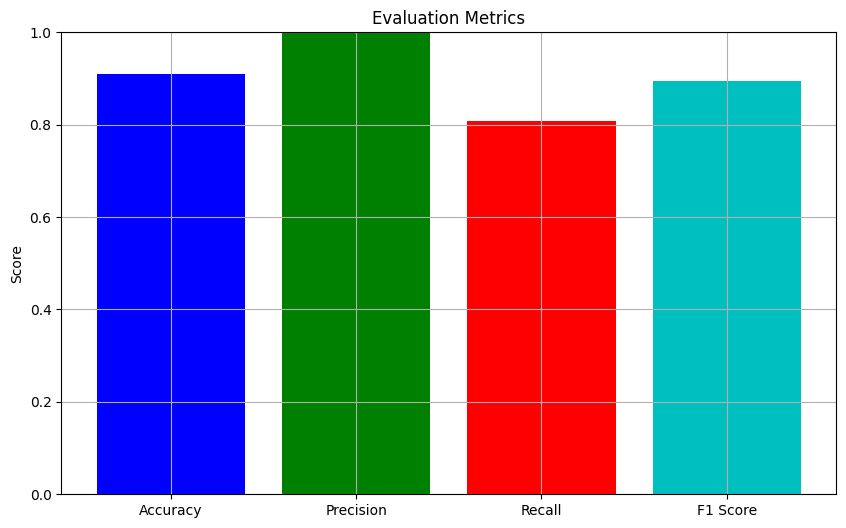

In [41]:


# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score  # Metrics import
import matplotlib.pyplot as plt
import numpy as np

model.eval()
y_true = []
y_pred = []

# Evaluation Loop
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        # Move data to device and convert to float32
        batch_x, batch_y = batch_x.to(device, dtype=torch.float32), batch_y.to(device, dtype=torch.float32)

        # Get predictions
        outputs = model(batch_x)
        y_true.extend(batch_y.cpu().numpy())  # Append ground truth
        y_pred.extend(outputs.cpu().numpy())  # Append predictions

# Convert predictions to binary (threshold at 0.5)
y_pred = (np.array(y_pred) > 0.5).astype(int)
y_true = np.array(y_true).astype(int)

# Calculate Metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Print Metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Visualize Metrics
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['b', 'g', 'r', 'c'])
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

def calculate_mcc(tp, tn, fp, fn):
    """
    Calculate the Matthews Correlation Coefficient (MCC).

    Parameters:
    tp (int): True Positives
    tn (int): True Negatives
    fp (int): False Positives
    fn (int): False Negatives

    Returns:
    float: The MCC score
    """
    # Calculate the MCC
    numerator = (tp * tn) - (fp * fn)
    denominator = np.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    if denominator == 0:
        return 0.0  # Return 0 if the denominator is zero to avoid division by zero

    return numerator / denominator


In [42]:

# Calculate tp, tn, fp, fn from y_true and y_pred
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

mcc_score = calculate_mcc(tp, tn, fp, fn)
print(f'MCC Score: {mcc_score:.4f}')

MCC Score: 0.8314


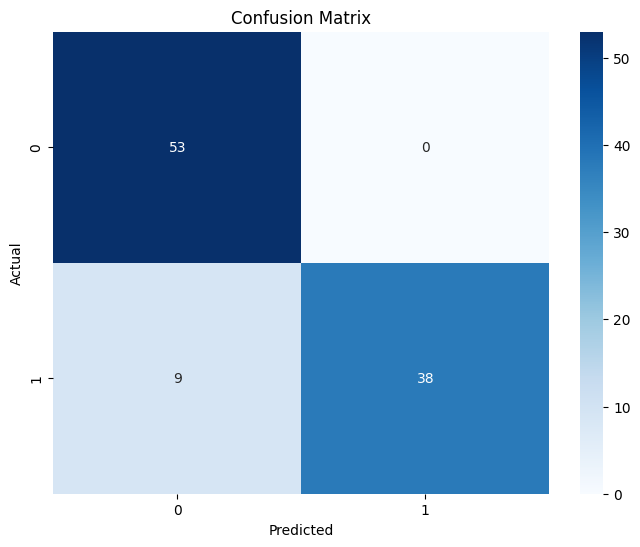

In [43]:


!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_true and y_pred are available as NumPy arrays
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

y_pred_proba = model(batch_x).detach().cpu().numpy()  # Store probabilities

ROC AUC: 1.0000


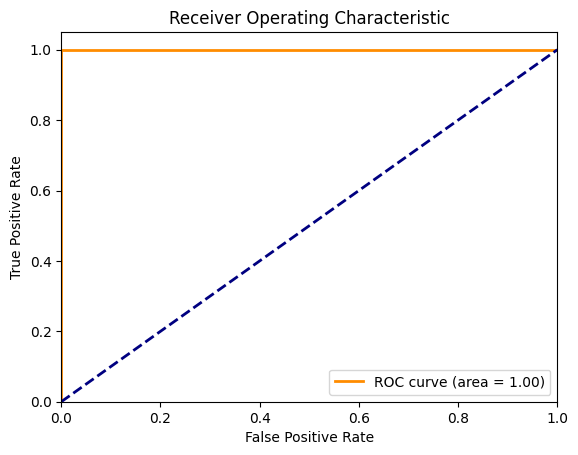

In [44]:
# Evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

model.eval()
y_true = []
y_pred = []
y_pred_proba = []  # Store probabilities for all batches

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x, batch_y = batch_x.to(device).to(torch.float32), batch_y.to(device).to(torch.float32)
        outputs = model(batch_x)
        y_true.extend(batch_y.cpu().numpy())
        y_pred.extend(outputs.cpu().numpy() > 0.5)  # Directly store binary predictions
        y_pred_proba.extend(outputs.cpu().numpy())  # Store probabilities

# Convert lists to numpy arrays
y_true = np.array(y_true).astype(int)
y_pred = np.array(y_pred).astype(int)
y_pred_proba = np.array(y_pred_proba).squeeze()  # Squeeze to get a 1D array of probabilities


# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [45]:


import numpy as np

variance = np.var(y_pred_proba)
print("Variance of model predictions:", variance)

def count_layers(model):
    """Counts the number of layers in a PyTorch model."""
    layer_count = 0
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Linear, torch.nn.Conv2d, torch.nn.BatchNorm2d, torch.nn.ReLU, torch.nn.MaxPool2d)):  # Add other layer types as needed
            layer_count += 1
    return layer_count

num_layers = count_layers(model)
print(f"The model has {num_layers} layers.")

Variance of model predictions: 0.18172488
The model has 125 layers.


In [46]:


# Assuming 'model' is your PyTorch model, 'test_data', and 'test_labels' are your test data
import torch

# Define your loss function
criterion = torch.nn.CrossEntropyLoss()

# ... (Your PyTorch evaluation loop)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    # Move x_data to the same device as the model
    x_data = x_data.to(device)
    outputs = model(x_data)
    # Assuming 'predicted_label' should be a tensor of class indices
    # Replace this with the actual way to get the correct class indices for your data
    predicted_label = torch.tensor([0] * len(outputs)).to(device)  # Example: all samples belong to class 0 and move to device
    loss = criterion(outputs, predicted_label)
    _, predicted = torch.max(outputs, 1)
    top1_accuracy = (predicted == predicted_label).sum().item() / len(predicted_label)

print("Test Loss:",loss.item())
print("Top-1 Accuracy:", top1_accuracy)




Test Loss: 0.0
Top-1 Accuracy: 1.0


In [ ]:
# from sklearn.metrics import precision_recall_curve
# from torch.utils.data import DataLoader  # Import DataLoader

# # Assuming you have your validation data in x_val and y_val
# # Create a TensorDataset for validation data
# val_dataset = TensorDataset(x_data, y_data)  # Replace x_data and y_data with your actual validation data

# # Create the val_loader
# val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# # Get model outputs for the validation set
# with torch.no_grad():
#     val_outputs = []
#     val_labels = []
#     for batch_x, batch_y in val_loader:
#         batch_x = batch_x.to(device).to(torch.float32)
#         val_outputs.extend(model(batch_x).cpu().numpy())
#         val_labels.extend(batch_y.cpu().numpy())

# # Precision-recall curve
# precision, recall, thresholds = precision_recall_curve(val_labels, val_outputs)

# # Select the threshold that maximizes the F1 score
# epsilon = 1e-7  # Small value to avoid division by zero
# f1_scores = 2 * (precision * recall) / (precision + recall + epsilon)
# optimal_idx = f1_scores.argmax()
# optimal_threshold = thresholds[optimal_idx]

# print(f"Optimal Threshold: {optimal_threshold:.4f}")

# # Calculate class weights
# from sklearn.utils.class_weight import compute_class_weight

# # Assuming y_data from your previous code contains the training labels
# train_labels = y_data.cpu().numpy()  # Convert y_data to NumPy array if needed

# # Reshape train_labels to a 1D array if it's multi-dimensional
# train_labels = train_labels.reshape(-1)

# # Now compute the class weights:
# class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
# class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# # Use the weights in the loss function
# criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

# from torchvision import transforms

# train_transforms = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
# for epoch in range(epochs):
#     model.train()
#     epoch_loss = 0
#     for batch_x, batch_y in train_loader:
#         batch_x, batch_y = batch_x.to(device).to(torch.float32), batch_y.to(device).to(torch.float32)
#         optimizer.zero_grad()
#         outputs = model(batch_x)
#         loss = criterion(outputs, batch_y)
#         loss.backward()
#         optimizer.step()
#         epoch_loss += loss.item()

#     epoch_loss /= len(train_loader)
#     scheduler.step(epoch_loss)  # Adjust learning rate
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# # Assuming xception_model and inception_model are keras functional models
# # and you want to freeze specific layers during training
# for layer in xception_model.layers:
#     if layer.__class__.__name__ in ["Conv2D", "BatchNormalization", "Dense"]:  # Add more layer types as needed
#         layer.trainable = False

# for layer in inception_model.layers:
#     if layer.__class__.__name__ in ["Conv2D", "BatchNormalization", "Dense"]:
#         layer.trainable = False

# # You can use a similar approach to unfreeze layers later:
# for layer in xception_model.layers[-10:]:
#     layer.trainable = True

# for layer in inception_model.layers[-10:]:
#     layer.trainable = True

# from torchvision import models
# import torch.nn as nn
# import torch.optim as optim
# import torch
# from transformers import ViTFeatureExtractor, ViTModel

# # Data Augmentation
# transform = transforms.Compose([
#     transforms.RandomResizedCrop(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
#     transforms.RandomRotation(15),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # Regularization (L2)
# optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

# class HybridXceptionInceptionModel(nn.Module):
#     def __init__(self):
#         super(HybridXceptionInceptionModel, self).__init__()
#         self.xception = models.xception(pretrained=True)
#         self.inception_v3 = models.inception_v3(pretrained=True, aux_logits=False)
#         self.vit_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
#         self.vit_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
#         self.dropout = nn.Dropout(0.5)  # Adjust dropout probability as needed

#         # Replace the fully connected layer with a new one that combines features from Xception and InceptionV3
#         self.fc = nn.Linear(self.xception.fc.in_features + self.inception_v3.fc.in_features + self.vit_model.config.hidden_size, 1)
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):
#         # Xception feature extraction
#         xception_features = self.xception(x)

#         # InceptionV3 feature extraction
#         inception_features = self.inception_v3(x)

#         # Apply dropout
#         xception_features = self.dropout(xception_features)
#         inception_features = self.dropout(inception_features)

#         # Preprocess input for ViT
#         inputs = self.vit_feature_extractor(images=x, return_tensors="pt").to(x.device)
#         vit_outputs = self.vit_model(**inputs).last_hidden_state
#         vit_features = vit_outputs[:, 0, :]  # Use the [CLS] token embedding as the ViT feature

#         # Combine features from Xception, InceptionV3, and ViT
#         # This is where 'concatenated' is defined
#         concatenated = torch.cat([xception_features, inception_features, vit_features], dim=1)

#         # Final output
#         output = self.fc(concatenated)  # Use 'concatenated' here
#         output = self.sigmoid(output)
#         return output

# # Combine the outputs of Xception and Inception models
# xception_output = xception_model.output  # Output from the Xception model
# inception_output = inception_model.output  # Output from the InceptionV3 model

# # Perform GlobalAveragePooling to reduce the feature dimensions
# x_xception = GlobalAveragePooling2D()(xception_output)
# x_inception = GlobalAveragePooling2D()(inception_output)

# # Concatenate the features from both models
# concatenated = Concatenate()([x_xception, x_inception])  # Define 'concatenated' here

# # Add fully connected layers on top of the concatenated features
# x_combined = Dense(512, activation='relu')(concatenated)
# x_combined = Dropout(0.3)(x_combined)
# predictions = Dense(1, activation='sigmoid')(x_combined)

# # Define the final hybrid model
# model = Model(inputs=[xception_model.input, inception_model.input], outputs=predictions)

# from sklearn.model_selection import KFold

# kf = KFold(n_splits=5)
# for train_idx, val_idx in kf.split(dataset):
#     train_subset = torch.utils.data.Subset(dataset, train_idx)
#     val_subset = torch.utils.data.Subset(dataset, val_idx)
#     # Train and evaluate your model on each split

# import numpy as np
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# # Ensure the model is in evaluation mode (not necessary in Keras, it's default during inference)
# y_true = []
# y_pred = []

# # Iterate over test data
# for batch_x, batch_y in test_loader:
#     # Convert batch_x and batch_y to NumPy arrays if needed
#     batch_x = np.array(batch_x)
#     batch_y = np.array(batch_y)

#     # Reshape batch_x to ensure it has the shape (batch_size, height, width, channels)
#     batch_x = np.transpose(batch_x, (0, 2, 3, 1))  # Change shape from (32, 3, 299, 299) to (32, 299, 299, 3)

#     # Use model.predict for predictions
#     outputs = model.predict([batch_x, batch_x])  # Assuming two identical inputs for the hybrid model
#     y_true.extend(batch_y)
#     y_pred.extend(outputs)

# # Convert predictions to binary labels (e.g., for binary classification tasks)
# y_pred = (np.array(y_pred) > 0.5).astype(int)
# y_true = np.array(y_true).astype(int)

# # Calculate evaluation metrics
# accuracy = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)

# # Print metrics
# print(f"Accuracy: {accuracy:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")
# print(f"F1 Score: {f1:.4f}")

# # Optionally, plot the metrics
# import matplotlib.pyplot as plt

# metrics = {
#     'Accuracy': accuracy,
#     'Precision': precision,
#     'Recall': recall,
#     'F1 Score': f1
# }

# plt.figure(figsize=(10, 6))
# plt.bar(metrics.keys(), metrics.values(), color=['b', 'g', 'r', 'c'])
# plt.title('Evaluation Metrics')
# plt.ylabel('Score')
# plt.ylim(0, 1)
# plt.grid(True)
# plt.show()

# model.save('best_hybrid_model.keras') # Use model.save to save a Keras model

# from tensorflow import keras

# model = keras.models.load_model('best_hybrid_model.keras')



# from tensorflow import keras

# model = keras.models.load_model('best_hybrid_model.keras')


# from sklearn.metrics import accuracy_score

# kf = KFold(n_splits=5)
# fold_accuracies = []

# for train_idx, val_idx in kf.split(dataset):
#     # Create subsets for training and validation
#     train_subset = torch.utils.data.Subset(dataset, train_idx)
#     val_subset = torch.utils.data.Subset(dataset, val_idx)

#     # Create data loaders
#     train_loader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True)
#     val_loader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False)

#     # Initialize your model and optimizer here
#     # model = create_hybrid_model().to(device)  # Remove .to(device) as it's a Keras model
#     model = create_hybrid_model()  # Create the Keras model

#     # Compile the model
#     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) # Compile before training

#     # Convert data to NumPy for Keras
#     x_train = np.array([x.numpy() for x, _ in train_loader])
#     y_train = np.array([y.numpy() for _, y in train_loader])
#     x_val = np.array([x.numpy() for x, _ in val_loader])
#     y_val = np.array([y.numpy() for _, y in val_loader])

#     # Reshape data to fit model input shape
#     x_train = x_train.reshape(-1, 299, 299, 3) # Assuming input size is (299, 299, 3)
#     x_val = x_val.reshape(-1, 299, 299, 3)

#     # Train the Keras model
#     model.fit([x_train, x_train], y_train, epochs=epochs, batch_size=32, validation_data=([x_val, x_val], y_val))


#     # Evaluate the model on the validation set
#     # (Keras model evaluation)
#     y_pred_proba = model.predict([x_val, x_val])
#     y_pred = (y_pred_proba > 0.5).astype(int)
#     current_fold_accuracy = accuracy_score(y_val, y_pred)
#     fold_accuracies.append(current_fold_accuracy)

# # Calculate the mean accuracy across all folds
# mean_accuracy = np.mean(fold_accuracies)
# print(f"Cross-Validation Mean Accuracy: {mean_accuracy:.4f}")
# # Enhancements to Hybrid Model (Xception + InceptionV3) with comprehensive evaluation metrics

# # Add metrics such as ROC-AUC, Precision-Recall Curve, and Variance of predictions
# from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report

# # Function to evaluate the model
# def evaluate_model(model, x_test, y_test):
#     # Predict probabilities
#     y_pred_proba = model.predict([x_test, x_test])
#     y_pred = (y_pred_proba > 0.5).astype(int)

#     # Metrics calculation
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)

#     # Confusion Matrix
#     cm = confusion_matrix(y_test, y_pred)
#     print("Confusion Matrix:")
#     print(cm)

#     # ROC-AUC
#     fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#     roc_auc = auc(fpr, tpr)

#     # Precision-Recall Curve
#     precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)

#     # Variance of predictions
#     variance = np.var(y_pred_proba)

#     # Print metrics
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")
#     print(f"ROC-AUC: {roc_auc:.4f}")
#     print(f"Variance of Predictions: {variance:.4f}")

#     # Plot ROC Curve
#     plt.figure()
#     plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic')
#     plt.legend()
#     plt.show()

#     # Plot Precision-Recall Curve
#     plt.figure()
#     plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
#     plt.xlabel('Recall')
#     plt.ylabel('Precision')
#     plt.title('Precision-Recall Curve')
#     plt.legend()
#     plt.show()

#     return cm, roc_auc, variance

# # Ensure to call evaluate_model() after training and testing the model.


In [48]:
pip install graphviz


In [49]:
from graphviz import Digraph

# Create a new directed graph
workflow = Digraph(format="png", name="Training_Workflow", node_attr={'shape': 'box', 'style': 'rounded'})

# Define the nodes of the workflow
workflow.node("start", "START")
workflow.node("load", "Load Dataset")
workflow.node("preprocess", "Preprocess Data")
workflow.node("dataloader", "Create DataLoaders")
workflow.node("define_model", "Define Model")
workflow.node("move_model", "Move Model to Device (CPU/GPU)")
workflow.node("init", "Initialize Optimizer, Loss Function, Scheduler")
workflow.node("epoch_loop", "FOR each epoch (1 to N):")
workflow.node("train_mode", "Training Mode")
workflow.node("batch_loop", "FOR each batch in train_loader:")
workflow.node("forward", "Forward Pass: batch_x -> model -> predictions")
workflow.node("loss", "Compute Loss: criterion(predictions, batch_y)")
workflow.node("backward", "Backward Pass: Compute gradients")
workflow.node("update", "Update Weights: optimizer.step()")
workflow.node("accumulate", "Accumulate Loss")
workflow.node("avg_loss", "Average Loss for the Epoch")
workflow.node("adjust_lr", "Adjust Learning Rate (Scheduler)")
workflow.node("validation", "Validation Mode (Optional)")
workflow.node("val_loss", "Compute Validation Loss")
workflow.node("log", "Log Epoch Loss, Validation Loss")
workflow.node("end", "END")

workflow.edges([
    ("start", "load"),
    ("load", "preprocess"),
    ("preprocess", "dataloader"),
    ("dataloader", "define_model"),
    ("define_model", "move_model"),
    ("move_model", "init"),
    ("init", "epoch_loop"),
    ("epoch_loop", "train_mode"),
    ("train_mode", "batch_loop"),
    ("batch_loop", "forward"),
    ("forward", "loss"),
    ("loss", "backward"),
    ("backward", "update"),
    ("update", "accumulate"),
    ("accumulate", "batch_loop"),
    ("batch_loop", "avg_loss"),  # Removed the dictionary here
    ("avg_loss", "adjust_lr"),
    ("adjust_lr", "validation"),
    ("validation", "val_loss"),
    ("val_loss", "log"),
    ("log", "epoch_loop"),
    ("epoch_loop", "end")
])

# Add edge with constraint separately
workflow.edge("batch_loop", "avg_loss", constraint='false')  # This line adds the constraint attribute correctly

# Render the diagram to a file
workflow.render("training_workflow", cleanup=True)  # Generates 'training_workflow.png'


'training_workflow.png'